In [42]:
# Generic Comment
#* Important Comment
#! Warning
#? Suggestion
#TODO Todo list

import time
start_time = time.time()
import cyipopt
import math
import matplotlib.pyplot as plt
import numpy as np
from cyipopt import minimize_ipopt
from phe import paillier
from numba import *
%matplotlib widget

def compute_index(indices, dims):
    if len(indices) == 1:
        return indices[0]
    else:
        current_index = indices[0]
        remaining_dims_product = 1
        for dim in dims[1:]:
            remaining_dims_product *= dim
        return current_index * remaining_dims_product + compute_index(indices[1:], dims[1:])
        
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to import Modules = %f seconds " % total_runtime)

Total time required to import Modules = 0.002517 seconds 


In [43]:
start_time = time.time()

public_key, private_key = paillier.generate_paillier_keypair(n_length=256)
d1=12
def encrypt(val):
    return public_key.encrypt(val,precision = 2**(-d1))
def decrypt(val):
    return private_key.decrypt(val)

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Encryption dependencies = %f seconds " % total_runtime)

Total time required to initialize Encryption dependencies = 0.005509 seconds 


In [44]:
start_time = time.time()
######### Simulation time #########################

hc = 1e-4  # hr Numerical Integration Step Size
tFinal = 5  # hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps = int( tFinal / hc)  # Number of calculated steps


controlStepSize   = 10 # Integration Steps per MPC Control Step
setpointStepSize  = 2 # Integration Steps per Set-Point        
PIcontrolStepSize = 1   # Integration Steps per PI Control Step

NUM_MPC_ITERATION = int(netTimeSteps/controlStepSize)  # Number of times simulation is run
HORIZON_LENGTH = 7

netControlTimeSteps   = int( netTimeSteps / controlStepSize   )
netSetPointTimeSteps  = int( netTimeSteps / setpointStepSize  )
netPIControlTimeSteps = int( netTimeSteps / PIcontrolStepSize )

controlTimeStepsPerMPC   = int( HORIZON_LENGTH * netControlTimeSteps   / NUM_MPC_ITERATION )
setpointTimeStepsPerMPC  = int( HORIZON_LENGTH * netSetPointTimeSteps  / NUM_MPC_ITERATION )
PIControlTimeStepsPerMPC = int( HORIZON_LENGTH * netPIControlTimeSteps / NUM_MPC_ITERATION )
timeStepsPerMPC          = int( HORIZON_LENGTH * netTimeSteps          / NUM_MPC_ITERATION )

controlTimeStepsPerControlAction   = int( netControlTimeSteps   / NUM_MPC_ITERATION )
setpointTimeStepsPerControlAction  = int( netSetPointTimeSteps  / NUM_MPC_ITERATION )
PIControlTimeStepsPerControlAction = int( netPIControlTimeSteps / NUM_MPC_ITERATION )
timeStepsPerControlAction          = int( netTimeSteps          / NUM_MPC_ITERATION )

NUM_OUTPUTS = 2  # Model Outputs: x1 x2
NUM_INPUTS = 4  # Model  Inputs: u1 u2 x1 x2
NUM_U = int(NUM_INPUTS - NUM_OUTPUTS)  # Number of control inputs


NUM_MPC_INPUTS = int(NUM_U * controlTimeStepsPerMPC)  # 1 set of control inputs per Horizon
NUM_MPC_CONSTRAINTS = controlTimeStepsPerMPC  # Constraints must be satisfied at all points

delta = controlStepSize * hc  # Step size for the system model
################### P matrix #############################
# V= xTP(x) "Energy of Sys"

a = 1060
b = 22
d = 0.52

###########Q Matrices for Cost Function##############
# Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
# Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
loopsPerHour = int((1.0/hc)/controlStepSize)
A1 = np.repeat(np.array([1, 0.99, 1.01, 0.98, 1.02]),loopsPerHour)
A2 = np.repeat(np.array([17, 14, 5, 7, 9]),loopsPerHour)
A3 = np.repeat(np.array([1e-8, 0.8 * 1e-8, 0.84 * 1e-8, 0.9 * 1e-8, 0.92e-8]),loopsPerHour)

end_time = time.time()
total_runtime = end_time - start_time
print(
    "Total time required to initialize Control Paramters = %f seconds " % total_runtime
)

Total time required to initialize Control Paramters = 0.000999 seconds 


In [45]:
start_time = time.time()
##################### initial values and initializations ######################

# Initial Values in Deviation Variable Form
CA = 0  # kmol/m3
T = 0  # K

setpoint_record  = np.zeros((NUM_OUTPUTS, netSetPointTimeSteps))
V_record         = np.zeros(netTimeSteps)
x_record         = np.zeros((NUM_OUTPUTS, netTimeSteps + 1))
x_real           = np.array([[CA], [T]])
x_record[:, [0]] = x_real


u_record        = np.zeros((NUM_U, netPIControlTimeSteps))
uMPC_record     = np.zeros((NUM_U, netControlTimeSteps))
#grad_f_record = []

encrypted_e1 = []
encrypted_e2 = []

message_record    = []

status_record     = np.zeros(NUM_MPC_ITERATION)
cost_record       = np.zeros(NUM_MPC_ITERATION)
constraint_record = np.zeros((controlTimeStepsPerMPC,NUM_MPC_ITERATION))

realtime_data = None
cost = 0.0

################################ Parameters ######################

# Flowrate Terms
F = 5  # m^3/hr
V = 1  # m^3

# Thermochemical Properties
rhoe_L = 1e3  # kg/m3
Cp = 0.231  # kJ/kg-K
deltaH = -1.15e4  # kJ/kmol
E = 5e4  # kJ/kmol
R = 8.314  # kJ/kmolK
k0 = 8.46e6  # m3/kmol-h

# Thermal Properties
T0 = 300  # K

###################Simplifications################################
E_over_R = -E / R  # K
Coeff1 = F / V
Coeff2 = (deltaH * k0) / (rhoe_L * Cp)
Coeff3 = V * rhoe_L * Cp
######################## steady state values ########################
# Invariant Parameters
T0s = 300  # K

# State Variables
CAs = 1.9537  # kmol/m3
Ts = 401.87  # K

# Control Variables
Qs = 0.0  # kJ/hr
CA0s = 4  # kmol/m3

end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize Model Paramters = %f seconds " % total_runtime)

Total time required to initialize Model Paramters = 0.002002 seconds 


In [46]:
start_time = time.time()
@njit
def model_makestep(CA, T, CA0, Q, steps=1):
    for _ in range(steps):
        exp_E_over_R_Ts__CAs = np.exp(E_over_R / (Ts)) * (CAs) ** 2
        exp_E_over_R_T__CA   = np.exp(E_over_R / (T + Ts)) * (CA + CAs) ** 2
        fun_1 = (
            Coeff1 * (CA0 - CA)
            - k0 * exp_E_over_R_T__CA 
            + k0 * exp_E_over_R_Ts__CAs 
        )
        fun_2 = (
            Coeff1 * (T0 - T0s - T)
            - Coeff2 * exp_E_over_R_T__CA
            + Coeff2 * exp_E_over_R_Ts__CAs
            + (Q) / Coeff3
        )
        CA += hc * fun_1
        T  += hc * fun_2
    return CA, T
def solvePI(CA,T,CA_setpoint,T_setpoint):
    encrypted_CA_setpoint = encrypt(CA_setpoint)
    encrypted_T_setpoint  = encrypt(T_setpoint)
    encrypted_CA          = encrypt(CA)
    encrypted_T           = encrypt(T)
    encrypted_error1      = encrypted_CA_setpoint-encrypted_CA
    encrypted_error2      = encrypted_T_setpoint-encrypted_T
    encrypted_e1.append(encrypted_error1)
    encrypted_e2.append(encrypted_error2)

    Kc1    = 10
    Kc2    = 10000
    K_I1 = 20
    K_I2 = 20
    encrypted_CA0 = Kc1*encrypted_error1+K_I1*(PIcontrolStepSize*hc*sum(encrypted_e1))
    encrypted_Q   = Kc2*encrypted_error2+K_I2*(PIcontrolStepSize*hc*sum(encrypted_e2))
    CA0           = decrypt(encrypted_CA0)
    Q             = decrypt(encrypted_Q)
    if (CA0   < CAO_L):
        CA0   = CAO_L
    elif(CA0  > CAO_U):
        CA0   = CAO_U
    if (Q     < Q_L):
        Q     = Q_L
    elif(Q    > Q_U):
        Q     = Q_U
    return [CA0,Q]
def solvePI2(CA,T,CA_setpoint,T_setpoint):
    encrypted_CA_setpoint = encrypt(CA_setpoint)
    encrypted_T_setpoint  = encrypt(T_setpoint)
    encrypted_CA          = encrypt(CA)
    encrypted_T           = encrypt(T)
    encrypted_error1      = encrypted_CA_setpoint-encrypted_CA
    encrypted_error2      = encrypted_T_setpoint-encrypted_T
    encrypted_e1.append(encrypted_error1)
    encrypted_e2.append(encrypted_error2)

    Kc1    = 1000
    Kc2    = 1000000
    K_I1 = 2
    K_I2 = 2
    encrypted_CA0 = Kc1*encrypted_error1+K_I1*(PIcontrolStepSize*hc*sum(encrypted_e1))
    encrypted_Q   = Kc2*encrypted_error2+K_I2*(PIcontrolStepSize*hc*sum(encrypted_e2))
    CA0           = decrypt(encrypted_CA0)
    Q             = decrypt(encrypted_Q)
    if (CA0   < CAO_L):
        CA0   = CAO_L
    elif(CA0  > CAO_U):
        CA0   = CAO_U
    if (Q     < Q_L):
        Q     = Q_L
    elif(Q    > Q_U):
        Q     = Q_U
    return [CA0,Q]
CAO_L = -3.5
CAO_U = 3.5
Q_L = -5e5
Q_U = 5e5
end_time = time.time()
total_runtime = end_time - start_time
print("Total time required to initialize MPC Constraints = %f seconds " % total_runtime)

Total time required to initialize MPC Constraints = 0.001999 seconds 


C:\Users\arthu\AppData\Local\Temp\ipykernel_26796\4000748116.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


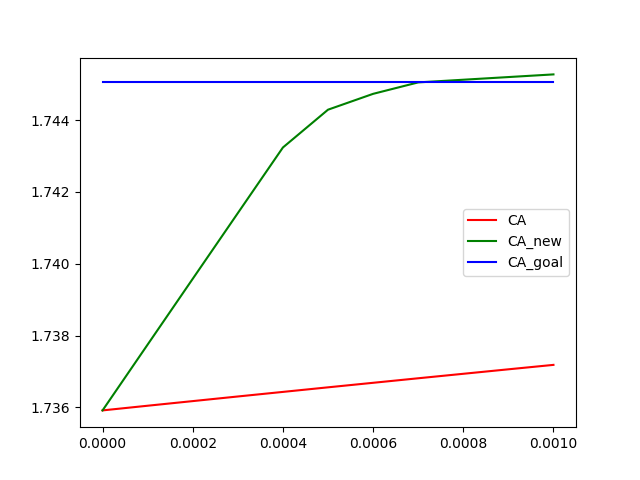

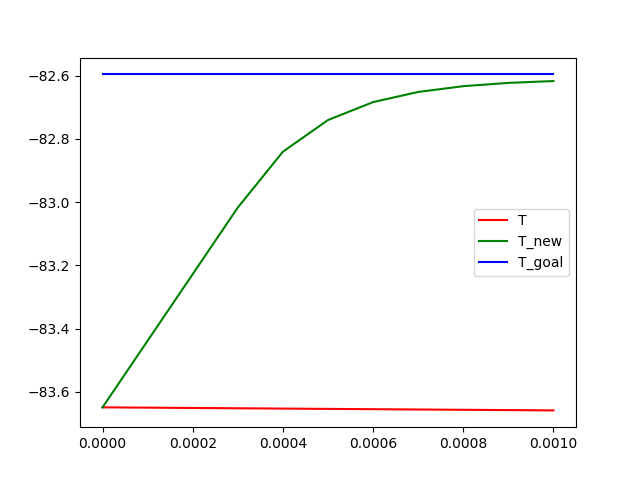

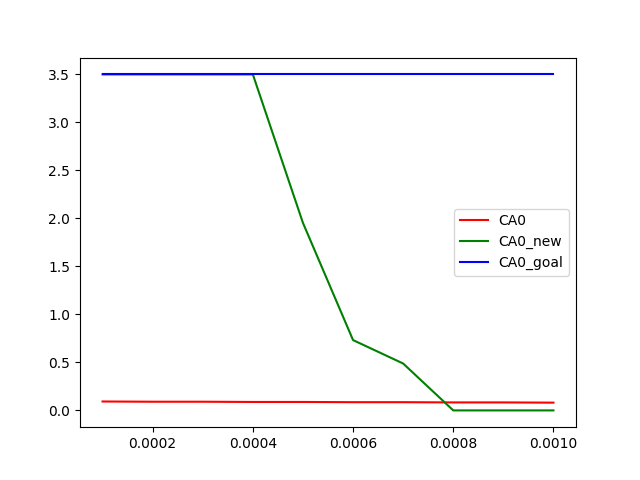

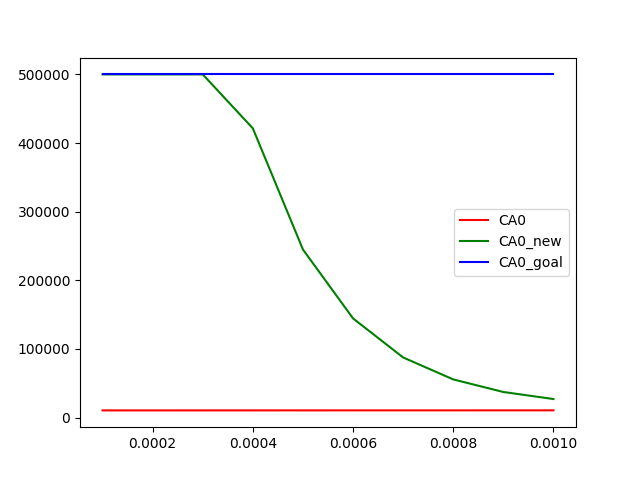

In [47]:
#Kc1=10
#Kc2=8000
#tau_I1=0.1;
#tau_I2=0.0001;
CA = 1.7359153021124671
T  = -83.64945054557043
CA_setpoint=1.7450648290113535
T_setpoint= -82.5955259443009

CA_record = [CA]
T_record = [T]
CA0_record = []
Q_record = []
setpointStepSize = 10
for i in range(setpointStepSize):
    CA0 , Q = solvePI(CA,T,CA_setpoint,T_setpoint)
    CA  , T = model_makestep(CA,T,CA0,Q)
    CA0_record.append(CA0)
    Q_record.append(Q)
    CA_record.append(CA)
    T_record.append(T)
CA = 1.7359153021124671
T  = -83.64945054557043
CA_setpoint=1.7450648290113535
T_setpoint= -82.5955259443009

CA_record2 = [CA]
T_record2 = [T]
CA0_record2 = []
Q_record2 = []
for i in range(setpointStepSize):
    CA0 , Q = solvePI2(CA,T,CA_setpoint,T_setpoint)
    CA  , T = model_makestep(CA,T,CA0,Q)
    CA0_record2.append(CA0)
    Q_record2.append(Q)
    CA_record2.append(CA)
    T_record2.append(T)
t=np.linspace(0,hc*setpointStepSize,setpointStepSize+1)
CA_MPC = [CA_setpoint]*(setpointStepSize+1)
plt.figure()
plt.plot(t,CA_record,'r',label='CA')
plt.plot(t,CA_record2,'g',label='CA_new')
plt.plot(t,CA_MPC,'b',label='CA_goal')
plt.legend()
plt.show()
T_MPC = [T_setpoint]*(setpointStepSize+1)
plt.figure()
plt.plot(t,T_record,'r',label='T')
plt.plot(t,T_record2,'g',label='T_new')
plt.plot(t,T_MPC,'b',label='T_goal')
plt.legend()
plt.show()

t=np.linspace(hc,hc*setpointStepSize,setpointStepSize)
CA0_MPC = [3.5]*(setpointStepSize)
plt.figure()
plt.plot(t,CA0_record,'r',label='CA0')
plt.plot(t,CA0_record2,'g',label='CA0_new')
plt.plot(t,CA0_MPC,'b',label='CA0_goal')
plt.legend()
plt.show()
Q_MPC = [5e5]*(setpointStepSize)
plt.figure()
plt.plot(t,Q_record,'r',label='CA0')
plt.plot(t,Q_record2,'g',label='CA0_new')
plt.plot(t,Q_MPC,'b',label='CA0_goal')
plt.legend()
plt.show()

In [48]:
import os
import pickle
from math import cos, pi, sin

import numpy as np
from matplotlib import pyplot as plt

# plt.rcParams['text.usetex'] = True

A, B, C, F = 1060, 44, 0.52, -90
A2, B2, C2, F2 = 1060, 44, 0.52, -320
angle = 0.5 * np.arctan(B / (A - C))  # rotation angle
A_prime = A * (cos(angle)) ** 2 + B * cos(angle) * sin(angle) + C * (sin(angle)) ** 2
C_prime = A * (sin(angle)) ** 2 - B * cos(angle) * sin(angle) + C * (cos(angle)) ** 2
a = np.sqrt(-F / A_prime)  # radius on the x-axis
b = np.sqrt(-F / C_prime)  # radius on the y-axis
C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

A_prime2 = (
    A2 * (cos(angle)) ** 2 + B2 * cos(angle) * sin(angle) + C2 * (sin(angle)) ** 2
)
C2_prime = (
    A2 * (sin(angle)) ** 2 - B2 * cos(angle) * sin(angle) + C2 * (cos(angle)) ** 2
)
a2 = np.sqrt(-F2 / A_prime2)  # radius on the x-axis
b2 = np.sqrt(-F2 / C2_prime)  # radius on the y-axis
C_A_limit = np.sqrt(a**2 * (cos(angle)) ** 2 + b**2 * (sin(angle)) ** 2)
T_limit = np.sqrt(a**2 * (sin(angle)) ** 2 + b**2 * (cos(angle)) ** 2)

u, v = 0, 0  # Unstable

t = np.linspace(0, 2 * pi, 100)
Ell = np.array(
    [a * np.cos(t), b * np.sin(t)]
)  # u,v removed to keep the same center location
R_rot = np.array(
    [[cos(angle), -sin(angle)], [sin(angle), cos(angle)]]
)  # 2-D rotation matrix

Ell_rot = np.zeros((2, Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:, i] = np.dot(R_rot, Ell[:, i])


Ell2 = np.array(
    [a2 * np.cos(t), b2 * np.sin(t)]
)  # u,v removed to keep the same center location
R_rot2 = np.array(
    [[cos(angle), -sin(angle)], [sin(angle), cos(angle)]]
)  # 2-D rotation matrix

Ell_rot2 = np.zeros((2, Ell2.shape[1]))
for i in range(Ell2.shape[1]):
    Ell_rot2[:, i] = np.dot(R_rot2, Ell2[:, i])

plt.figure(5)
plt.plot(u + Ell_rot[0, :], v + Ell_rot[1, :])
plt.plot(u + Ell_rot2[0, :], v + Ell_rot2[1, :])  # Rotated ellipse
for i in range(10):
    plt.plot(y_record[0, :], y_record[1, :], "o", alpha=0.2, markersize=1)
plt.plot(y_record[0], y_record[1])
for i in range(10):
    plt.plot(yEnc_record[0, :], yEnc_record[1, :], "o", alpha=0.2, markersize=1)
plt.plot(yEnc_record[0], yEnc_record[1])
plt.grid(color="lightgray", linestyle="--")
plt.xlim(-2, 2)
plt.ylim(-80, 80)
plt.xticks([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2])
plt.yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80])
plt.xlabel("Concentration, Ca-Cas (kmol/m^3)")
plt.ylabel("Temperature, T-Ts (K)")
plt.savefig("ellipse.pdf")

NameError: name 'y_record' is not defined

In [ ]:
uEnc_record[0,:][:20]

array([-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5])

In [ ]:
u_record[0,:][:20]

array([-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5])

In [ ]:
for i in [  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127]:
    d1=8
    l1=i
    Q_l = -2**(l1-d1-1);
    Q_u = 2**(l1-d1-1) - 2**(-d1);
    def quant1(val):
        return np.fmin(np.fmax(np.round(val / (2 ** (-d1))) * (2 ** (-d1)), Q_l), Q_u)
    def quant2(val):
        return int(((2**d1) * val) % (2**l1))

    print("2**l1 is ",(2**l1),", and we get ",quant2(quant1(-(2**(-d1))))," vs ",((2**l1)-1), "for l1=",i)

2**l1 is  512 , and we get  511  vs  511 for l1= 9
2**l1 is  1024 , and we get  1023  vs  1023 for l1= 10
2**l1 is  2048 , and we get  2047  vs  2047 for l1= 11
2**l1 is  4096 , and we get  4095  vs  4095 for l1= 12
2**l1 is  8192 , and we get  8191  vs  8191 for l1= 13
2**l1 is  16384 , and we get  16383  vs  16383 for l1= 14
2**l1 is  32768 , and we get  32767  vs  32767 for l1= 15
2**l1 is  65536 , and we get  65535  vs  65535 for l1= 16
2**l1 is  131072 , and we get  131071  vs  131071 for l1= 17
2**l1 is  262144 , and we get  262143  vs  262143 for l1= 18
2**l1 is  524288 , and we get  524287  vs  524287 for l1= 19
2**l1 is  1048576 , and we get  1048575  vs  1048575 for l1= 20
2**l1 is  2097152 , and we get  2097151  vs  2097151 for l1= 21
2**l1 is  4194304 , and we get  4194303  vs  4194303 for l1= 22
2**l1 is  8388608 , and we get  8388607  vs  8388607 for l1= 23
2**l1 is  16777216 , and we get  16777215  vs  16777215 for l1= 24
2**l1 is  33554432 , and we get  33554431  vs  33

In [ ]:
CA =  1.7359153021124671
T =  -83.64945054557043
print(model_makestep(CA,T,3.5,5e5,5))

(1.7450648290113535, -82.5955259443009)


In [ ]:
quant1(-(2**(-d1)))

In [ ]:
((2**d1) * quant1(-(2**(-d1)))) % (2**l1)

In [ ]:
private_key.decrypt(public_key.encrypt(0.003906250001,precision = 2**-d1))

In [ ]:
public_key.max_int/(2**256)

In [ ]:
public_key.n/(2**255)

In [ ]:
import math
math.floor(math.log(2**-d1, 2))

In [ ]:
int(round(0.04*pow(2,8)))

In [ ]:
math.log(private_key.decrypt(public_key.encrypt(public_key.n/3) * (public_key.n/3)),2)

In [ ]:
19641000836739309015932978236435367068379431240072146367049031995645054471925/public_key.n

In [ ]:
math.log((public_key.n**2)/9,2)

In [ ]:
import numpy as np
CA_setpoint,T_setpoint= 0.0,0.0
print(CA_setpoint)
print(T_setpoint)


0.0
0.0


In [ ]:
!conda list

# packages in environment at C:\Users\arthu\miniforge3\envs\JupyterNotebook:
#
# Name                    Version                   Build  Channel
aiofiles                  24.1.0                   pypi_0    pypi
aiosqlite                 0.20.0                   pypi_0    pypi
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312he70551f_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
astroid                   3.2.3           py312h2e8e312_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
asyncua                   1.1.5                    pypi_0    pypi
attrs                     23.2.0             pyh71513ae_0    conda-forge
autopep8                  2.0.4              pyhd8ed1ab_0    conda-forge